In [1]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectFpr, f_classif
from DataPreprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler
from FeatureSelection import FeatureSelection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from pandas_ml import ConfusionMatrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import sys
import operator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def update_progress(job_title, progress):
    length = 20 # modify this to change the length
    block = int(round(length*progress))
    msg = "\r{0}: [{1}] {2}%".format(job_title, "#"*block + "-"*(length-block), round(progress*100, 2))
    if progress >= 1: msg += " DONE\r\n"
    sys.stdout.write(msg)
    sys.stdout.flush()

### READ IN TRAINING AND TEST DATA FROM FILE

In [3]:
test_df = pd.read_csv("census-income.test.csv", sep=",", names=['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status','occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

In [4]:
df = pd.read_csv("census-income.data.csv", sep=",", names=['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status','occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])

#### Preprocess test data and training data by deleting missing values, removing leading and trailing white spaces as well as converting the categorical fields to numeric fields

In [5]:
dp = DataPreprocessor(test_df)
test_df = dp.runTestSetPreprocessor()

In [6]:
dpp = DataPreprocessor(df)
train_df = dpp.runProjectPreprocessor()

In [7]:
len(train_df.columns)

78

#### Remove prediction class from both the training data and test data, and convert both to numpy arrays in preparation for feature selection

In [8]:
Y = train_df['income'].values
train_df = train_df.drop('income', axis=1)
X = train_df.values

In [9]:
Y_test = test_df['income'].values
test_df = test_df.drop('income', axis=1)
X_test = test_df.values

In [94]:
X.shape

(17508, 77)

### FEATURE SELECTION


In [10]:
def extractRFEFeatureColumns(data):
    outt = []
    for i,j in enumerate(data):
        if j == True:
            outt.append(i)
    return outt   

fs = FeatureSelection()
features_range = list(range(1,81))
chi2_features = {}
rfe_features = {}
rfe_forest_features = {}
rfe_dt_features= {}
rfe_svm_features = {}
rfe_nb_features = {}
rfe_knn_features ={}

#### Run Feature selection algorithms for range provided above in order to select the best features within said range

In [11]:
def runChi2FeatureSelection():
    for i, feat in enumerate(features_range):
        if i > 76:
            fit, features_list = fs.runUnivariateSelectionMethod(X,Y,'chi2', 'all')
            print (feat)
        else:
            fit, features_list = fs.runUnivariateSelectionMethod(X,Y,'chi2', feat)
        chi2_features[feat] = features_list
        update_progress("Chi2 Selection Process", i/len(features_range))
    update_progress("Chi2 Selection Process", 1)


In [12]:
def runRFEFeatureSelectionLR():
    for i,feat in enumerate(features_range):
        fit2 = fs.runRFESelectionMethod(X,Y,feat)
        rfe_features[feat] = extractRFEFeatureColumns(fit2.support_)
        update_progress("RFE Selection Process", i/len(features_range))
    update_progress("RFE Selection Process", 1)

In [13]:
def runRFEFeatureSelectionRF():
    for i,feat in enumerate(features_range):
        fit3 = fs.runRFESelectionMethodRF(X,Y,feat)
        rfe_forest_features[feat] = extractRFEFeatureColumns(fit3.support_)
        update_progress("RFE Selection Process", i/len(features_range))
    update_progress("RFE Selection Process", 1)

In [14]:
runChi2FeatureSelection()

Chi2 Selection Process: [###################-] 95.0%%78
Chi2 Selection Process: [###################-] 96.25%79
Chi2 Selection Process: [####################] 97.5%80
Chi2 Selection Process: [####################] 100% DONE


In [15]:
runRFEFeatureSelectionLR()

RFE Selection Process: [####################] 100% DONE


In [16]:
runRFEFeatureSelectionRF()

RFE Selection Process: [####################] 100% DONE


In [17]:
def plotAccuracyForModelFeatures(models):
    plot_list = [v['to_plot'] for k,v in models.items()]
    plot_list
    x = list(zip(*plot_list))[0]
    y = list(zip(*plot_list))[1]
    plt.plot(x, y)
    
    
def getMaximumAccuracyFeatures(data):
    plot_list = [v['to_plot'] for k,v in data.items()]
    
    return max(plot_list, key=lambda item:item[1])

# DATA MODELLING SECTION

## LOGISTIC REGRESSION


In [18]:
def runLogisticRegressionModel(train_x, train_y, test_x, test_y):
    model = LogisticRegression()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateLogisticRegressionWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateLogisticRegressionWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def logisticRegressioinTrainSet(train_x, train_y):
    
    model = LogisticRegression()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateLogisticRegressionWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE LOGISTIC REGRESSION with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runLogisticRegressionModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


#### LOGISTIC REGRESSION USING ALL FEATURES 

In [19]:
lr_cm, lr_report, lr_acc = runLogisticRegressionModel(X,Y,X_test,Y_test)
print("(Test SET)Accuracy when all features are used is: ", lr_acc*100, "%")
print(lr_cm.print_stats())

(Test SET)Accuracy when all features are used is:  80.5444887118 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4888
NegativeTest: 10172
TP: 2829
TN: 9301
FP: 2059
FN: 871
TPR: 0.764594594595
TNR: 0.81875
PPV: 0.578764320786
NPV: 0.914372788046
FPR: 0.18125
FDR: 0.421235679214
FNR: 0.235405405405
ACC: 0.805444887118
F1_score: 0.658826269213
MCC: 0.536347710754
informedness: 0.583344594595
markedness: 0.493137108831
prevalence: 0.245683930943
LRP: 4.21845293569
LRN: 0.287518052404
DOR: 14.6719585098
FOR: 0.0856272119544
None


In [20]:
lrt_cw, lrt_rep, lrt_acc = logisticRegressioinTrainSet(X,Y)
print("(Training SET) Accuracy when all features are used is: ", lrt_acc*100, "%")
print(lrt_cw.print_stats())
lrt_cw

(Training SET) Accuracy when all features are used is:  79.7863833676 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7749
NegativeTest: 9759
TP: 5859
TN: 8110
FP: 1890
FN: 1649
TPR: 0.780367607885
TNR: 0.811
PPV: 0.756097560976
NPV: 0.831027769239
FPR: 0.189
FDR: 0.243902439024
FNR: 0.219632392115
ACC: 0.797863833676
F1_score: 0.768040899259
MCC: 0.589242651255
informedness: 0.591367607885
markedness: 0.587125330214
prevalence: 0.428832533699
LRP: 4.12892914225
LRN: 0.270816759698
DOR: 15.2462098241
FOR: 0.168972230761
None


Predicted     0     1  __all__
Actual                        
0          8110  1890    10000
1          1649  5859     7508
__all__    9759  7749    17508

In [21]:
lr_rfe_models = automateLogisticRegressionWithRFE()
lr_chi2_models = automateLogisticRegressionWithChi2()
lr_rfe_forest = automateLogisticRegressionWithRFEForest()

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


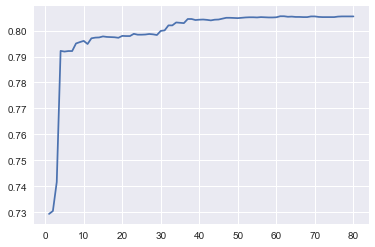

In [22]:
plotAccuracyForModelFeatures(lr_rfe_models)

In [23]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(lr_rfe_models)[1], " with ", getMaximumAccuracyFeatures(lr_rfe_models)[0], " features")

The best accuracy for rfe is:  0.805511288181  with  61  features


In [24]:
best_feats = getMaximumAccuracyFeatures(lr_rfe_models)[0]
lr_rfe_models[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4877
NegativeTest: 10183
TP: 2824
TN: 9307
FP: 2053
FN: 876
TPR: 0.763243243243
TNR: 0.819278169014
PPV: 0.579044494566
NPV: 0.913974270844
FPR: 0.180721830986
FDR: 0.420955505434
FNR: 0.236756756757
ACC: 0.805511288181
F1_score: 0.658505304885
MCC: 0.535904830633
informedness: 0.582521412257
markedness: 0.49301876541
prevalence: 0.245683930943
LRP: 4.22330406393
LRN: 0.288982137827
DOR: 14.6144121422
FOR: 0.0860257291564


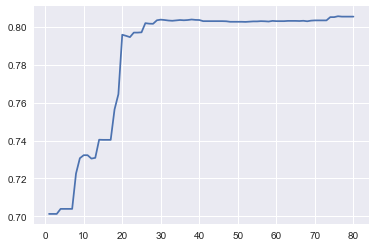

In [25]:
plotAccuracyForModelFeatures(lr_chi2_models)

In [26]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(lr_chi2_models)[1], " with ", getMaximumAccuracyFeatures(lr_chi2_models)[0], " features")
best_feats = getMaximumAccuracyFeatures(lr_chi2_models)[0]
lr_chi2_models[best_feats]['cm'].print_stats()

The best accuracy for chi2 is:  0.805644090305  with  76  features
population: 15060
P: 3700
N: 11360
PositiveTest: 4887
NegativeTest: 10173
TP: 2830
TN: 9303
FP: 2057
FN: 870
TPR: 0.764864864865
TNR: 0.818926056338
PPV: 0.579087374667
NPV: 0.914479504571
FPR: 0.181073943662
FDR: 0.420912625333
FNR: 0.235135135135
ACC: 0.805644090305
F1_score: 0.659135903109
MCC: 0.536786608538
informedness: 0.583790921203
markedness: 0.493566879238
prevalence: 0.245683930943
LRP: 4.22404709036
LRN: 0.287126210377
DOR: 14.7114646372
FOR: 0.0855204954291


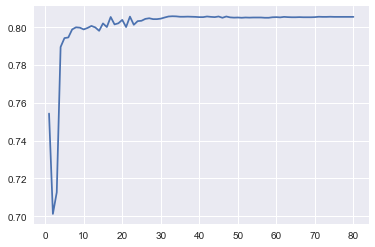

In [27]:
plotAccuracyForModelFeatures(lr_rfe_forest)

In [28]:
print("The best accuracy for RFE (FOREST) is: ", getMaximumAccuracyFeatures(lr_rfe_forest)[1], " with ", getMaximumAccuracyFeatures(lr_rfe_forest)[0], " features")
best_feats = getMaximumAccuracyFeatures(lr_rfe_forest)[0]
lr_rfe_forest[best_feats]['cm'].print_stats()

The best accuracy for RFE (FOREST) is:  0.80577689243  with  33  features
population: 15060
P: 3700
N: 11360
PositiveTest: 4881
NegativeTest: 10179
TP: 2828
TN: 9307
FP: 2053
FN: 872
TPR: 0.764324324324
TNR: 0.819278169014
PPV: 0.579389469371
NPV: 0.914333431575
FPR: 0.180721830986
FDR: 0.420610530629
FNR: 0.235675675676
ACC: 0.80577689243
F1_score: 0.659130637455
MCC: 0.536784794876
informedness: 0.583602493338
markedness: 0.493722900946
prevalence: 0.245683930943
LRP: 4.22928608102
LRN: 0.287662584686
DOR: 14.702245986
FOR: 0.0856665684252


## KNN ALGORITHM

In [29]:
def runKNNAlgorithmModel(train_x, train_y, test_x, test_y, neighbors=25):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(train_x, train_y)
    predicted = knn.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score


def automateKNNAlgorithmModelWithChi2():
    models = {}
    total = len(chi2_features)
    count=0
    for k,v in chi2_features.items():
        #print("******Chi2 KNN model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress("KNN 1", count/total)
        count = count+1
    update_progress("KNN 1", 1)        
    return models

def automateKNNAlgorithmModelWithRFE():
    models = {}
    total = len(rfe_features)
    count=0
    for k,v in rfe_features.items():
        #print("******RFE KNN Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress("KNN 2", count/total)
        count = count+1
    update_progress("KNN 3", 1)        
    return models

def knnOnTrainSet(train_x, train_y, neighbors=10):
    model = KNeighborsClassifier(n_neighbors=neighbors)
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score
def automateKNNAlgorithmModelWithRFEForest():
    models = {}
    total = len(rfe_forest_features)
    count=0
    for k,v in rfe_forest_features.items():
        #print("******RFE KNN Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runKNNAlgorithmModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        
        update_progress("KNN 3", count/total)
        count = count+1
    update_progress("KNN 3", 1)

    return models

#### KNN CROSS VALIDATION (Finding best value for K)

In [46]:
def knnFindBestValueK(train_x, train_y, k_len):
    mylist = list(range(1,k_len))
    neigh = list(filter(lambda x: x % 2 != 0, mylist)) ## IT HELPS TO HAVE ODD NUMBER FOR K'S
    cv_scores = {}
    for i, k in enumerate(neigh):
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, train_x, train_y, cv=10, scoring='accuracy')
        cv_scores[k] = scores.mean()
        update_progress("KNN Cross Validation", i/len(neigh))
    update_progress("KNN Cross Validation", 1)
        
    
    best_k=list(cv_scores.items())
    plt.plot(*zip(*best_k))
    plt.show()
    return cv_scores
    

KNN Cross Validation: [####################] 100% DONE


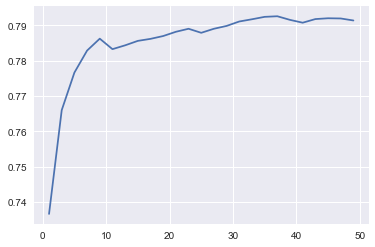

In [47]:
mydict = knnFindBestValueK(X,Y,50)

In [48]:

maxval = max(mydict.items(), key=operator.itemgetter(1))[1]
keys = [k for k,v in mydict.items() if v==maxval]
print("The best value for K is ", keys)

The best value for K is  [37]


#### RUN KNN WITH ALL FEATURES 

In [49]:
knn_cm, knn_report, knn_acc = runKNNAlgorithmModel(X,Y,X_test,Y_test)
print("(TEST SET) Accuracy when all features are used is: ", knn_acc*100, "%")
knn_cm.print_stats()

(TEST SET) Accuracy when all features are used is:  79.3625498008 %
population: 15060
P: 3700
N: 11360
PositiveTest: 5246
NegativeTest: 9814
TP: 2919
TN: 9033
FP: 2327
FN: 781
TPR: 0.788918918919
TNR: 0.795158450704
PPV: 0.556423942051
NPV: 0.920419808437
FPR: 0.204841549296
FDR: 0.443576057949
FNR: 0.211081081081
ACC: 0.793625498008
F1_score: 0.652582159624
MCC: 0.527743918493
informedness: 0.584077369623
markedness: 0.476843750488
prevalence: 0.245683930943
LRP: 3.85136180443
LRN: 0.265457885651
DOR: 14.5083721849
FOR: 0.0795801915631


In [50]:
knn_cmt, knn_reportt, knn_acct = knnOnTrainSet(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", knn_acct*100, "%")
knn_cmt.print_stats()

(TRAINING SET) Accuracy when all features are used is:  82.0824765821 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7291
NegativeTest: 10217
TP: 5831
TN: 8540
FP: 1460
FN: 1677
TPR: 0.776638252531
TNR: 0.854
PPV: 0.799753120285
NPV: 0.835861798963
FPR: 0.146
FDR: 0.200246879715
FNR: 0.223361747469
ACC: 0.820824765821
F1_score: 0.788026217988
MCC: 0.633121696009
informedness: 0.630638252531
markedness: 0.635614919248
prevalence: 0.428832533699
LRP: 5.31944008583
LRN: 0.261547713664
DOR: 20.3383161386
FOR: 0.164138201037


In [51]:
knn_model = automateKNNAlgorithmModelWithChi2()


KNN 1: [--------------------] 0.0%

/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNN 1: [####################] 100% DONE


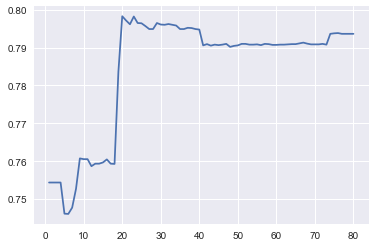

In [52]:
plotAccuracyForModelFeatures(knn_model)

In [53]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(knn_model)[1], " with ", getMaximumAccuracyFeatures(knn_model)[0], " features")

The best accuracy for chi2 is:  0.798273572377  with  20  features


In [54]:
best_feats = getMaximumAccuracyFeatures(knn_model)[0]
knn_model[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4856
NegativeTest: 10204
TP: 2759
TN: 9263
FP: 2097
FN: 941
TPR: 0.745675675676
TNR: 0.815404929577
PPV: 0.568163097199
NPV: 0.90778126225
FPR: 0.184595070423
FDR: 0.431836902801
FNR: 0.254324324324
ACC: 0.798273572377
F1_score: 0.644927536232
MCC: 0.516762178634
informedness: 0.561080605253
markedness: 0.475944359449
prevalence: 0.245683930943
LRP: 4.03952106613
LRN: 0.311899419661
DOR: 12.9513580709
FOR: 0.0922187377499


KNN 3: [####################] 100% DONE


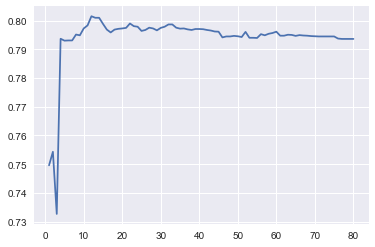

In [55]:
knn_model2 = automateKNNAlgorithmModelWithRFE()
plotAccuracyForModelFeatures(knn_model2)

In [56]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(knn_model2)[1], " with ", getMaximumAccuracyFeatures(knn_model2)[0], " features")

The best accuracy for rfe is:  0.801527224436  with  12  features


In [57]:
best_feats = getMaximumAccuracyFeatures(knn_model2)[0]
knn_model2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5033
NegativeTest: 10027
TP: 2872
TN: 9199
FP: 2161
FN: 828
TPR: 0.776216216216
TNR: 0.809771126761
PPV: 0.570633816809
NPV: 0.917422958013
FPR: 0.190228873239
FDR: 0.429366183191
FNR: 0.223783783784
ACC: 0.801527224436
F1_score: 0.657735028055
MCC: 0.5347850902
informedness: 0.585987342977
markedness: 0.488056774822
prevalence: 0.245683930943
LRP: 4.08043323286
LRN: 0.276354362842
DOR: 14.7652209681
FOR: 0.0825770419866


In [99]:
knn_model3 = automateKNNAlgorithmModelWithRFEForest()

KNN 3: [####################] 100% DONE


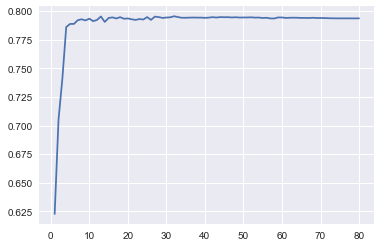

In [100]:
plotAccuracyForModelFeatures(knn_model3)


In [101]:
print("The best accuracy for rfe forest is: ", getMaximumAccuracyFeatures(knn_model3)[1], " with ", getMaximumAccuracyFeatures(knn_model3)[0], " features")

The best accuracy for rfe forest is:  0.795484727756  with  32  features


In [102]:
best_feats = getMaximumAccuracyFeatures(knn_model3)[0]
knn_model3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5170
NegativeTest: 9890
TP: 2895
TN: 9085
FP: 2275
FN: 805
TPR: 0.782432432432
TNR: 0.799735915493
PPV: 0.55996131528
NPV: 0.918604651163
FPR: 0.200264084507
FDR: 0.44003868472
FNR: 0.217567567568
ACC: 0.795484727756
F1_score: 0.652762119504
MCC: 0.527831372749
informedness: 0.582168347925
markedness: 0.478565966443
prevalence: 0.245683930943
LRP: 3.907003267
LRN: 0.272049264454
DOR: 14.3613814757
FOR: 0.0813953488372


## RANDOM FOREST

In [59]:
def runRandomForestModel(train_x, train_y, test_x, test_y):
    rf_model = RandomForestClassifier(n_jobs=2)
    rf_model.fit(train_x, train_y)
    predicted = rf_model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateRandomForestModelWithChi2():
    models = {}
    total = len(chi2_features)
    count=0
    for k,v in chi2_features.items():
        #print("******Chi2 Random Forest model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress("Random Forest chi2", count/total)
    update_progress("Random Forest chi2", 1)        
    return models

def automateRandomForestModelWithRFE():
    models = {}
    total = len(rfe_features)
    count=0    
    for k,v in rfe_features.items():
        #print("******RFE Random Forest Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress("Random Forest rfe", count/total)
    update_progress("Random Forest rfe", 1)          
    return models

def randomForestOnTrainSet(train_x, train_y):
    model = RandomForestClassifier(n_jobs=2)
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score


def automateRandomForestModelWithRFEForest():
    models = {}
    total = len(rfe_forest_features)
    count=0  
    for k,v in rfe_forest_features.items():
        #print("******RFE Random Forest Model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runRandomForestModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress("Random Forest rfe Forest", count/total)
    update_progress("Random Forest rfe Forest", 1)          
    return models


#### RANDOM FOREST USING ALL AVAILABLE FEATURES 

In [60]:
rf_cm, rf_report, rf_acc = runRandomForestModel(X,Y,X_test,Y_test)
print("(TEST SET) -- Accuracy when all features are used is: ", rf_acc*100, "%")
rf_cm.print_stats()

(TEST SET) -- Accuracy when all features are used is:  79.833997344 %
population: 15060
P: 3700
N: 11360
PositiveTest: 4487
NegativeTest: 10573
TP: 2575
TN: 9448
FP: 1912
FN: 1125
TPR: 0.695945945946
TNR: 0.831690140845
PPV: 0.573880098061
NPV: 0.893596897758
FPR: 0.168309859155
FDR: 0.426119901939
FNR: 0.304054054054
ACC: 0.79833997344
F1_score: 0.629046048614
MCC: 0.496646486687
informedness: 0.527636086791
markedness: 0.46747699582
prevalence: 0.245683930943
LRP: 4.13490896754
LRN: 0.365585738151
DOR: 11.310367271
FOR: 0.106403102242


In [61]:
rft_cm, rft_report, rft_acc = randomForestOnTrainSet(X,Y)
print("(TRAINING SET) -- Accuracy when all features are used is: ", rft_acc*100, "%")
rft_cm.print_stats()

(TRAINING SET) -- Accuracy when all features are used is:  98.423577793 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7390
NegativeTest: 10118
TP: 7311
TN: 9921
FP: 79
FN: 197
TPR: 0.973761321257
TNR: 0.9921
PPV: 0.989309878214
NPV: 0.980529748962
FPR: 0.0079
FDR: 0.0106901217862
FNR: 0.0262386787427
ACC: 0.98423577793
F1_score: 0.981474023359
MCC: 0.967848430134
informedness: 0.965861321257
markedness: 0.969839627176
prevalence: 0.428832533699
LRP: 123.260926741
LRN: 0.0264476149004
DOR: 4660.56872068
FOR: 0.0194702510378


Random Forest chi2: [####################] 100% DONE


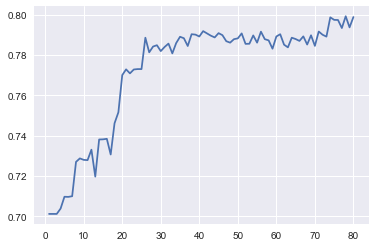

In [62]:
rf_chi2 = automateRandomForestModelWithChi2()
plotAccuracyForModelFeatures(rf_chi2)

In [63]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(rf_chi2)[1], " with ", getMaximumAccuracyFeatures(rf_chi2)[0], " features")

The best accuracy for chi2 is:  0.799136786189  with  78  features


In [64]:
best_feats = getMaximumAccuracyFeatures(rf_chi2)[0]
rf_chi2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4431
NegativeTest: 10629
TP: 2553
TN: 9482
FP: 1878
FN: 1147
TPR: 0.69
TNR: 0.834683098592
PPV: 0.576167907921
NPV: 0.892087684636
FPR: 0.165316901408
FDR: 0.423832092079
FNR: 0.31
ACC: 0.799136786189
F1_score: 0.627967039725
MCC: 0.495667020525
informedness: 0.524683098592
markedness: 0.468255592558
prevalence: 0.245683930943
LRP: 4.17380191693
LRN: 0.371398439148
DOR: 11.2380706998
FOR: 0.107912315364


Random Forest rfe: [####################] 100% DONE


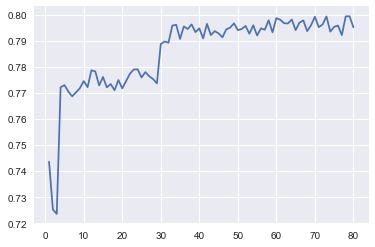

In [65]:
rf_rfe = automateRandomForestModelWithRFE()
plotAccuracyForModelFeatures(rf_rfe)

In [66]:
print("The best accuracy for rfe is: ", getMaximumAccuracyFeatures(rf_rfe)[1], " with ", getMaximumAccuracyFeatures(rf_rfe)[0], " features")

The best accuracy for rfe is:  0.799468791501  with  79  features


In [67]:
best_feats = getMaximumAccuracyFeatures(rf_rfe)[0]
rf_rfe[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4472
NegativeTest: 10588
TP: 2576
TN: 9464
FP: 1896
FN: 1124
TPR: 0.696216216216
TNR: 0.833098591549
PPV: 0.57602862254
NPV: 0.89384208538
FPR: 0.166901408451
FDR: 0.42397137746
FNR: 0.303783783784
ACC: 0.799468791501
F1_score: 0.630445423397
MCC: 0.498707853795
informedness: 0.529314807766
markedness: 0.46987070792
prevalence: 0.245683930943
LRP: 4.17142205497
LRN: 0.364643256951
DOR: 11.4397345226
FOR: 0.10615791462


Random Forest rfe Forest: [####################] 100% DONE


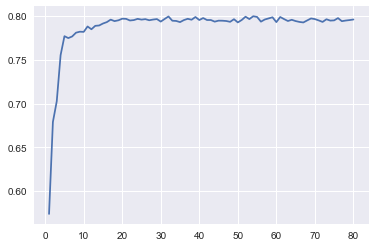

In [103]:
rf_rfe_forest = automateRandomForestModelWithRFEForest()
plotAccuracyForModelFeatures(rf_rfe_forest)

In [104]:
print("The best accuracy for rfe forest is: ", getMaximumAccuracyFeatures(rf_rfe_forest)[1], " with ", getMaximumAccuracyFeatures(rf_rfe_forest)[0], " features")

The best accuracy for rfe forest is:  0.799867197875  with  54  features


In [105]:
best_feats = getMaximumAccuracyFeatures(rf_rfe_forest)[0]
rf_rfe_forest[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 4412
NegativeTest: 10648
TP: 2549
TN: 9497
FP: 1863
FN: 1151
TPR: 0.688918918919
TNR: 0.836003521127
PPV: 0.577742520399
NPV: 0.89190458302
FPR: 0.163996478873
FDR: 0.422257479601
FNR: 0.311081081081
ACC: 0.799867197875
F1_score: 0.628451676529
MCC: 0.496516166391
informedness: 0.524922440046
markedness: 0.469647103419
prevalence: 0.245683930943
LRP: 4.20081530806
LRN: 0.372104989058
DOR: 11.2893280972
FOR: 0.10809541698


## NAIVE BAYES

In [68]:
def runNaiveBayesModel(train_x, train_y, test_x, test_y):
    model = GaussianNB()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateNaiveBayesModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Naive Bayes model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateNaiveBayesModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE Naive Bayes with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateNaiveBayesModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Naive Bayes with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runNaiveBayesModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


def trainSetNaiveBayes(train_x, train_y):
    model = GaussianNB()    
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

#### RUN NAIVE BAYES ON DATA WITH ALL FEATURES(77)

In [69]:
nb_cm, nb_report, nb_acc = runNaiveBayesModel(X,Y,X_test,Y_test)
print("(Test SET) Accuracy when all features are used is: ", nb_acc*100, "%")
nb_cm.print_stats()

(Test SET) Accuracy when all features are used is:  52.96812749 %
population: 15060
P: 3700
N: 11360
PositiveTest: 10329
NegativeTest: 4731
TP: 3473
TN: 4504
FP: 6856
FN: 227
TPR: 0.938648648649
TNR: 0.396478873239
PPV: 0.336237777132
NPV: 0.952018600719
FPR: 0.603521126761
FDR: 0.663762222868
FNR: 0.0613513513514
ACC: 0.5296812749
F1_score: 0.49511725711
MCC: 0.310809661333
informedness: 0.335127521888
markedness: 0.288256377851
prevalence: 0.245683930943
LRP: 1.55528714245
LRN: 0.154740530939
DOR: 10.0509358021
FOR: 0.0479813992813


In [70]:
nbt_cm, nbt_report, nbt_acc = trainSetNaiveBayes(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", nbt_acc*100, "%")
nbt_cm.print_stats()

(TRAINING SET) Accuracy when all features are used is:  63.4966872287 %
population: 17508
P: 7508
N: 10000
PositiveTest: 13169
NegativeTest: 4339
TP: 7143
TN: 3974
FP: 6026
FN: 365
TPR: 0.951385189132
TNR: 0.3974
PPV: 0.542410205786
NPV: 0.915879234847
FPR: 0.6026
FDR: 0.457589794214
FNR: 0.0486148108684
ACC: 0.634966872287
F1_score: 0.690912608212
MCC: 0.399805664327
informedness: 0.348785189132
markedness: 0.458289440633
prevalence: 0.428832533699
LRP: 1.578800513
LRN: 0.122332186383
DOR: 12.9058472646
FOR: 0.0841207651533


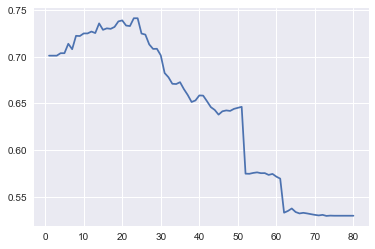

In [71]:
nb1 = automateNaiveBayesModelWithChi2()
plotAccuracyForModelFeatures(nb1)

In [72]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(nb1)[1], " with ", getMaximumAccuracyFeatures(nb1)[0], " features")

The best accuracy for chi2 is:  0.741367861886  with  23  features


In [73]:
best_feats = getMaximumAccuracyFeatures(nb1)[0]
nb1[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 6493
NegativeTest: 8567
TP: 3149
TN: 8016
FP: 3344
FN: 551
TPR: 0.851081081081
TNR: 0.705633802817
PPV: 0.484983828739
NPV: 0.935683436442
FPR: 0.294366197183
FDR: 0.515016171261
FNR: 0.148918918919
ACC: 0.741367861886
F1_score: 0.617875012263
MCC: 0.483933598436
informedness: 0.556714883898
markedness: 0.420667265181
prevalence: 0.245683930943
LRP: 2.89123238071
LRN: 0.211042779306
DOR: 13.6997455692
FOR: 0.0643165635578


/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


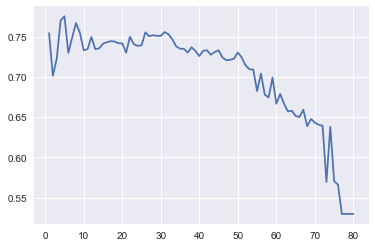

In [74]:
nb2 = automateNaiveBayesModelWithRFEForest()
plotAccuracyForModelFeatures(nb2)

In [75]:
print("The best accuracy for rfe (Random Forest) is: ", getMaximumAccuracyFeatures(nb2)[1], " with ", getMaximumAccuracyFeatures(nb2)[0], " features")

The best accuracy for rfe (Random Forest) is:  0.775298804781  with  5  features


In [76]:
best_feats = getMaximumAccuracyFeatures(nb2)[0]
nb2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5638
NegativeTest: 9422
TP: 2977
TN: 8699
FP: 2661
FN: 723
TPR: 0.804594594595
TNR: 0.765757042254
PPV: 0.528024122029
NPV: 0.923264699639
FPR: 0.234242957746
FDR: 0.471975877971
FNR: 0.195405405405
ACC: 0.775298804781
F1_score: 0.637609766545
MCC: 0.507339450595
informedness: 0.570351636848
markedness: 0.451288821668
prevalence: 0.245683930943
LRP: 3.43487207613
LRN: 0.255179377561
DOR: 13.460617817
FOR: 0.0767353003609


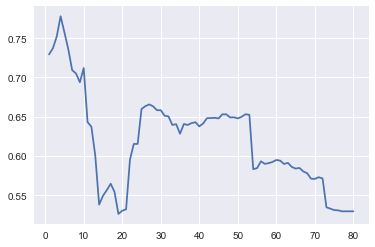

In [77]:
nb3 = automateNaiveBayesModelWithRFE()
plotAccuracyForModelFeatures(nb3)

In [78]:
print("The best accuracy for rfe (Logistic regression) is: ", getMaximumAccuracyFeatures(nb3)[1], " with ", getMaximumAccuracyFeatures(nb3)[0], " features")

The best accuracy for rfe (Logistic regression) is:  0.777888446215  with  4  features


In [79]:
best_feats = getMaximumAccuracyFeatures(nb3)[0]
nb3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5579
NegativeTest: 9481
TP: 2967
TN: 8748
FP: 2612
FN: 733
TPR: 0.801891891892
TNR: 0.770070422535
PPV: 0.531815737587
NPV: 0.922687480224
FPR: 0.229929577465
FDR: 0.468184262413
FNR: 0.198108108108
ACC: 0.777888446215
F1_score: 0.639508567734
MCC: 0.509861463903
informedness: 0.571962314427
markedness: 0.454503217811
prevalence: 0.245683930943
LRP: 3.48755432308
LRN: 0.257259728865
DOR: 13.5565497891
FOR: 0.0773125197764


## DECISION TREES

In [80]:
def runDecisionTreeModel(train_x, train_y, test_x, test_y):
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateDecisionTreeModelWithChi2():
    models = {}
    for k,v in chi2_features.items():
        #print("******Chi2 Support Vector Machine model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

def automateDecisionTreeModelWithRFE():
    models = {}
    for k,v in rfe_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models


def trainSetDecisionTree(train_x, train_y):
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateDecisionTreeModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runDecisionTreeModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

In [81]:
dt_cm, dt_report, dt_acc = runDecisionTreeModel(X,Y,X_test,Y_test)
print("(TEST SET) Accuracy when all features are used is: ", dt_acc*100, "%")
dt_cm.print_stats()

(TEST SET) Accuracy when all features are used is:  74.2961487384 %
population: 15060
P: 3700
N: 11360
PositiveTest: 5341
NegativeTest: 9719
TP: 2585
TN: 8604
FP: 2756
FN: 1115
TPR: 0.698648648649
TNR: 0.757394366197
PPV: 0.483991761842
NPV: 0.88527626299
FPR: 0.242605633803
FDR: 0.516008238158
FNR: 0.301351351351
ACC: 0.742961487384
F1_score: 0.571839398297
MCC: 0.410368253317
informedness: 0.456043014846
markedness: 0.369268024832
prevalence: 0.245683930943
LRP: 2.87977091751
LRN: 0.397879050599
DOR: 7.23780483836
FOR: 0.11472373701


In [82]:
dtt_cm, dtt_report, dtt_acc = trainSetDecisionTree(X,Y)
print("(TRAINING SET) Accuracy when all features are used is: ", dtt_acc*100, "%")
dtt_cm.print_stats()

(TRAINING SET) Accuracy when all features are used is:  99.9885766507 %
population: 17508
P: 7508
N: 10000
PositiveTest: 7506
NegativeTest: 10002
TP: 7506
TN: 10000
FP: 0
FN: 2
TPR: 0.999733617475
TNR: 1.0
PPV: 1.0
NPV: 0.999800039992
FPR: 0.0
FDR: 0.0
FNR: 0.000266382525306
ACC: 0.999885766507
F1_score: 0.999866790995
MCC: 0.999766828182
informedness: 0.999733617475
markedness: 0.999800039992
prevalence: 0.428832533699
LRP: inf
LRN: 0.000266382525306
DOR: inf
FOR: 0.000199960007998


/Users/ibrahimdawha/anaconda/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


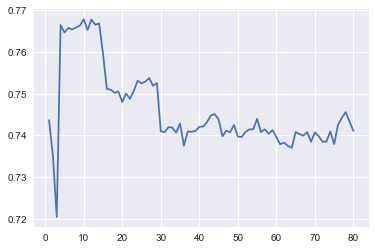

In [83]:
mm = automateDecisionTreeModelWithRFE()
plotAccuracyForModelFeatures(mm)

In [84]:
print("The best accuracy for rfe (Logistic regression) is: ", getMaximumAccuracyFeatures(mm)[1], " with ", getMaximumAccuracyFeatures(mm)[0], " features")

The best accuracy for rfe (Logistic regression) is:  0.767795484728  with  10  features


In [85]:
best_feats = getMaximumAccuracyFeatures(mm)[0]
mm[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5149
NegativeTest: 9911
TP: 2676
TN: 8887
FP: 2473
FN: 1024
TPR: 0.723243243243
TNR: 0.782306338028
PPV: 0.519712565547
NPV: 0.896680456059
FPR: 0.217693661972
FDR: 0.480287434453
FNR: 0.276756756757
ACC: 0.767795484728
F1_score: 0.604814103289
MCC: 0.458810764605
informedness: 0.505549581271
markedness: 0.416393021606
prevalence: 0.245683930943
LRP: 3.32229811696
LRN: 0.353770311326
DOR: 9.39111624292
FOR: 0.103319543941


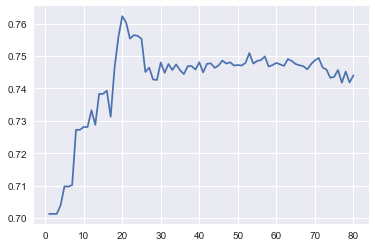

In [86]:
mm2 = automateDecisionTreeModelWithChi2()
plotAccuracyForModelFeatures(mm2)

In [87]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(mm2)[1], " with ", getMaximumAccuracyFeatures(mm2)[0], " features")

The best accuracy for chi2 is:  0.762284196547  with  20  features


In [88]:
best_feats = getMaximumAccuracyFeatures(mm2)[0]
mm2[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5110
NegativeTest: 9950
TP: 2615
TN: 8865
FP: 2495
FN: 1085
TPR: 0.706756756757
TNR: 0.78036971831
PPV: 0.511741682975
NPV: 0.890954773869
FPR: 0.21963028169
FDR: 0.488258317025
FNR: 0.293243243243
ACC: 0.762284196547
F1_score: 0.593643586833
MCC: 0.442904171965
informedness: 0.487126475067
markedness: 0.402696456844
prevalence: 0.245683930943
LRP: 3.21793857986
LRN: 0.375774759531
DOR: 8.56347718478
FOR: 0.109045226131


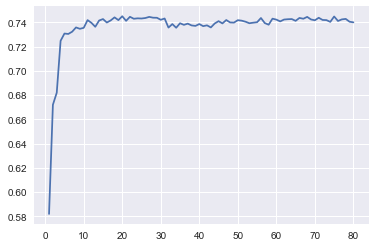

In [106]:
mm3 = automateDecisionTreeModelWithRFEForest()
plotAccuracyForModelFeatures(mm3)

In [107]:
print("The best accuracy for rfe (random forest) is: ", getMaximumAccuracyFeatures(mm3)[1], " with ", getMaximumAccuracyFeatures(mm3)[0], " features")

The best accuracy for rfe (random forest) is:  0.745019920319  with  20  features


In [108]:
best_feats = getMaximumAccuracyFeatures(mm3)[0]
mm3[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5182
NegativeTest: 9878
TP: 2521
TN: 8699
FP: 2661
FN: 1179
TPR: 0.681351351351
TNR: 0.765757042254
PPV: 0.486491702046
NPV: 0.880643855031
FPR: 0.234242957746
FDR: 0.513508297954
FNR: 0.318648648649
ACC: 0.745019920319
F1_score: 0.567664940329
MCC: 0.405153537761
informedness: 0.447108393605
markedness: 0.367135557077
prevalence: 0.245683930943
LRP: 2.90873782463
LRN: 0.416122387475
DOR: 6.99010173973
FOR: 0.119356144969


## SUPPORT VECTOR MACHINES

In [89]:
def runSupportVectorMachineModel(train_x, train_y, test_x, test_y, kernel='rbf'):
    svm_model = svm.SVC()
    svm_model.fit(train_x, train_y)
    predicted = svm_model.predict(test_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(test_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(Y_test, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(Y_test, predicted), "\n"
    accuracy_score = metrics.accuracy_score(Y_test, predicted)
    cm = ConfusionMatrix(Y_test, predicted)
    return cm, report,accuracy_score

def automateSVMModelWithChi2():
    models = {}
    total = len(chi2_features)
    count = 0    
    for k,v in chi2_features.items():
        #print("******Chi2 Support Vector Machine model with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score, "to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress('SVM chi2', count/total)
        count = count + 1
    update_progress('SVM chi2', 1)
    return models

def automateSVMModelWithRFE():
    models = {}
    total = len(rfe_features)
    count = 0
    for k,v in rfe_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
        update_progress('SVM rfe', count/total)
        count = count + 1
    update_progress('SVM rfe', 1)

    return models

def automateSVMModelWithRFBKernel():
    models = {}
    #print("******RFB Kernel Support Vector Machine ****** \n")

    cm, report, score = runSupportVectorMachineModel(X, Y, X_test, Y_test)
    models = {"cm":cm, "report":report, "accuracy":score}
    #print("Accuracy: ", score*100, "%\n")
    return models

def automateSVMModelWithPolyKernel(train_x, train_y, test_x, test_y):
    models = {}
    #print("******Poly Kernel Support Vector Machine ****** \n")

    cm, report, score = runSupportVectorMachineModel(train_x, train_y, test_x, test_y, kernel='poly')
    models = {"cm":cm, "report":report, "accuracy":score}
    #print("Accuracy: ", score*100, "%\n")
    return models


def svmOnTrainSet(train_x, train_y):
    model = svm.SVC()
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def svmOnTrainSetPoly(train_x, train_y):
    model = svm.SVC(kernel='poly')
    model.fit(train_x, train_y)
    predicted = model.predict(train_x)
    report = "-- CLASSIFICATION REPORT -- \n", metrics.classification_report(train_y, predicted), "-- CONFUSION MATRIX --  \n", confusion_matrix(train_y, predicted), "\n", "-- ACCURACY SCORE -- \n ", metrics.accuracy_score(train_y, predicted), "\n"
    accuracy_score = metrics.accuracy_score(train_y, predicted)
    cm = ConfusionMatrix(train_y, predicted)
    return cm, report,accuracy_score

def automateSVMModelWithRFEForest():
    models = {}
    for k,v in rfe_forest_features.items():
        #print("******RFE Support Vector Machine with "+ str(k)+ " Features!****** \n")
        train_selected = X[:, v]
        test_selected = X_test[:, v]
        cm, report, score = runSupportVectorMachineModel(train_selected, Y, test_selected, Y_test)
        models[k] = {"cm":cm, "report":report, "accuracy":score,"to_plot":(k,score)}
        #print("Accuracy: ", score*100, "%\n")
    return models

#### RUN SVM DATASET WITH ALL FEATURES (77)

In [90]:
svm_cm, svm_report, svm_acc = runSupportVectorMachineModel(X,Y,X_test,Y_test)
print("(TEST SET) RBF kernel Accuracy when all features are used is: ", svm_acc*100, "%")
svm_cm.print_stats()

(TEST SET) RBF kernel Accuracy when all features are used is:  77.2377158035 %
population: 15060
P: 3700
N: 11360
PositiveTest: 5516
NegativeTest: 9544
TP: 2894
TN: 8738
FP: 2622
FN: 806
TPR: 0.782162162162
TNR: 0.769190140845
PPV: 0.524655547498
NPV: 0.915549036044
FPR: 0.230809859155
FDR: 0.475344452502
FNR: 0.217837837838
ACC: 0.772377158035
F1_score: 0.628038194444
MCC: 0.492653844936
informedness: 0.551352303007
markedness: 0.440204583542
prevalence: 0.245683930943
LRP: 3.38877275445
LRN: 0.283204147155
DOR: 11.9658302624
FOR: 0.0844509639564


In [91]:
svmt_cm, svmt_report, svmt_acc = svmOnTrainSet(X,Y)
print("(TRAINING SET) RBF kernel Accuracy when all features are used is: ", svmt_acc*100, "%")
svmt_cm.print_stats()

(TRAINING SET) RBF kernel Accuracy when all features are used is:  77.016221156 %
population: 17508
P: 7508
N: 10000
PositiveTest: 8234
NegativeTest: 9274
TP: 5859
TN: 7625
FP: 2375
FN: 1649
TPR: 0.780367607885
TNR: 0.7625
PPV: 0.711561816857
NPV: 0.822191071814
FPR: 0.2375
FDR: 0.288438183143
FNR: 0.219632392115
ACC: 0.77016221156
F1_score: 0.744378096811
MCC: 0.538290956523
informedness: 0.542867607885
markedness: 0.533752888671
prevalence: 0.428832533699
LRP: 3.28575834899
LRN: 0.288042481462
DOR: 11.4072005362
FOR: 0.177808928186


In [109]:
svm_ply_cm, svm_ply_rep, svm_ply_acc = automateSVMModelWithPolyKernel(X,Y,X_test,Y_test)
print("(Test SET) POLY kernel Accuracy when all features are used is: ", svm_ply_acc*100, "%")


(Test SET) POLY kernel Accuracy when all features are used is:  accuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracyaccuracy %


In [110]:
svm_ply_cm

'cm'

In [111]:
svm_ply2_cm, svm_ply2_rep, svm_ply2_acc = svmOnTrainSetPoly(X,Y)
print("(Train SET) POLY kernel Accuracy when all features are used is: ", svm_ply2_acc*100, "%")
svm_ply2_cm.print_stats()

(Train SET) POLY kernel Accuracy when all features are used is:  73.0237605666 %
population: 17508
P: 7508
N: 10000
PositiveTest: 8181
NegativeTest: 9327
TP: 5483
TN: 7302
FP: 2698
FN: 2025
TPR: 0.730287693127
TNR: 0.7302
PPV: 0.670211465591
NPV: 0.782888388549
FPR: 0.2698
FDR: 0.329788534409
FNR: 0.269712306873
ACC: 0.730237605666
F1_score: 0.698961055517
MCC: 0.456778837721
informedness: 0.460487693127
markedness: 0.45309985414
prevalence: 0.428832533699
LRP: 2.70677425177
LRN: 0.369367716889
DOR: 7.32812892952
FOR: 0.217111611451


SVM chi2: [####################] 100% DONE


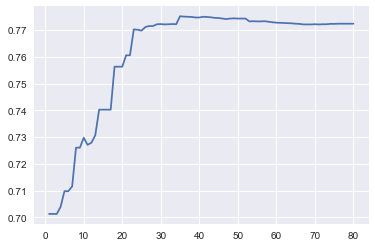

In [92]:
sv_ch = automateSVMModelWithChi2()
plotAccuracyForModelFeatures(sv_ch)

In [93]:
best_feats = getMaximumAccuracyFeatures(sv_ch)[0]
sv_ch[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5458
NegativeTest: 9602
TP: 2886
TN: 8788
FP: 2572
FN: 814
TPR: 0.78
TNR: 0.773591549296
PPV: 0.528765115427
NPV: 0.915225994584
FPR: 0.226408450704
FDR: 0.471234884573
FNR: 0.22
ACC: 0.775166002656
F1_score: 0.630268617602
MCC: 0.495771849206
informedness: 0.553591549296
markedness: 0.443991110011
prevalence: 0.245683930943
LRP: 3.44510108865
LRN: 0.284387801548
DOR: 12.1140958575
FOR: 0.0847740054155


In [95]:
print("The best accuracy for chi2 is: ", getMaximumAccuracyFeatures(sv_ch)[1], " with ", getMaximumAccuracyFeatures(sv_ch)[0], " features")

The best accuracy for chi2 is:  0.775166002656  with  35  features


SVM rfe: [####################] 100% DONE


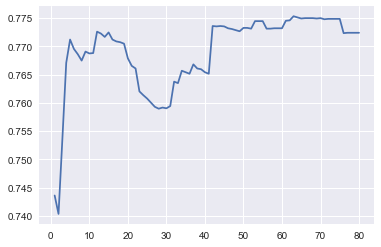

In [96]:
sv_rfe = automateSVMModelWithRFE()
plotAccuracyForModelFeatures(sv_rfe)

In [97]:
best_feats = getMaximumAccuracyFeatures(sv_rfe)[0]
sv_rfe[best_feats]['cm'].print_stats()

population: 15060
P: 3700
N: 11360
PositiveTest: 5470
NegativeTest: 9590
TP: 2893
TN: 8783
FP: 2577
FN: 807
TPR: 0.781891891892
TNR: 0.773151408451
PPV: 0.528884826325
NPV: 0.915849843587
FPR: 0.226848591549
FDR: 0.471115173675
FNR: 0.218108108108
ACC: 0.775298804781
F1_score: 0.630970556161
MCC: 0.49683699436
informedness: 0.555043300343
markedness: 0.444734669912
prevalence: 0.245683930943
LRP: 3.44675665188
LRN: 0.282102710703
DOR: 12.2180912168
FOR: 0.0841501564129


In [98]:
print("The best accuracy for RFE is: ", getMaximumAccuracyFeatures(sv_rfe)[1], " with ", getMaximumAccuracyFeatures(sv_rfe)[0], " features")

The best accuracy for RFE is:  0.775298804781  with  63  features
